In [6]:
import torch

times = torch.linspace(0, 1, 100+1)[:-1]
i = 0

for t in times:
    print(t.item())
    i += 1
    print(i)
print(1 - 1/101)

0.0
1
0.009999999776482582
2
0.019999999552965164
3
0.029999999329447746
4
0.03999999910593033
5
0.04999999701976776
6
0.05999999865889549
7
0.07000000029802322
8
0.07999999821186066
9
0.08999999612569809
10
0.09999999403953552
11
0.10999999940395355
12
0.11999999731779099
13
0.12999999523162842
14
0.14000000059604645
15
0.14999999105930328
16
0.1599999964237213
17
0.17000000178813934
18
0.17999999225139618
19
0.1899999976158142
20
0.19999998807907104
21
0.20999999344348907
22
0.2199999988079071
23
0.22999998927116394
24
0.23999999463558197
25
0.25
26
0.25999999046325684
27
0.26999998092651367
28
0.2800000011920929
29
0.28999999165534973
30
0.29999998211860657
31
0.3100000023841858
32
0.3199999928474426
33
0.32999998331069946
34
0.3400000035762787
35
0.3499999940395355
36
0.35999998450279236
37
0.3700000047683716
38
0.3799999952316284
39
0.38999998569488525
40
0.3999999761581421
41
0.4099999964237213
42
0.41999998688697815
43
0.429999977350235
44
0.4399999976158142
45
0.449999988079071

In [1]:
import torch

start_time = 0.0
end_time = 1.0
eps = 1e-6
num_integration_steps = 5
x0 = torch.zeros(1)  # 디바이스를 CPU로 설정

times = torch.linspace(start_time + eps, end_time - eps, num_integration_steps + 1, device=x0.device)[:-1]
print(times)

tensor([1.0000e-06, 2.0000e-01, 4.0000e-01, 6.0000e-01, 8.0000e-01])


In [5]:
import torch

times = torch.linspace(0, 1, 10)  # 예시
K = 3  # 뽑고 싶은 개수

# 1. 전체 인덱스 섞기 (shuffle)
random_indices = torch.randperm(times.shape[0])  # [0,1,2,...,9]를 랜덤 순서로 섞음

# 2. K개 인덱스만 추출
selected_indices = random_indices[:K]

# 3. 해당 인덱스의 값 뽑기
random_values = times[selected_indices]

print("원본 times:", times)
print("섞인 random_indices:", random_indices)
print("선택된 selected_indices:", selected_indices)
print("추출된 random_values:", random_values)

원본 times: tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000])
섞인 random_indices: tensor([6, 2, 5, 3, 1, 4, 0, 7, 9, 8])
선택된 selected_indices: tensor([6, 2, 5])
추출된 random_values: tensor([0.6667, 0.2222, 0.5556])


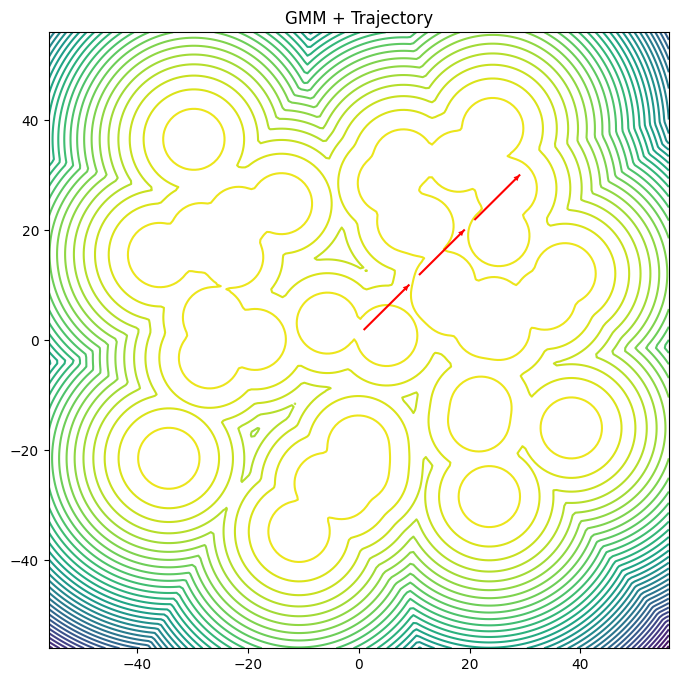

In [13]:
import torch
from dem.energies.gmm_energy import GMM
from typing import Optional

import matplotlib.pyplot as plt
import torch
from fab.target_distributions import gmm
from fab.utils.plotting import plot_contours, plot_marginal_pair
from lightning.pytorch.loggers import WandbLogger

from dem.energies.base_energy_function import BaseEnergyFunction
from dem.models.components.replay_buffer import ReplayBuffer
from dem.utils.logging_utils import fig_to_image

def draw_gmm_with_trajectory(
    ax: plt.Axes,
    log_prob_func,               # e.g. your GMM's .log_prob
    trajectory: torch.Tensor,    # shape (T, 2) or (T, num_sample, 2)
    bounds=(-1.4*40, 1.4*40),
    n_contour_levels=50,
    grid_width_n_points=200,
    lineparams=None,
    arrowparams=None,
    title="GMM + Trajectory"
):
    """
    Draws the GMM background (via plot_contours) and overlays a 2D trajectory.

    Parameters
    ----------
    ax             : matplotlib Axes where we draw
    log_prob_func  : function(x: Tensor) -> Tensor giving log p(x)
                     typically 'energy_function.gmm.log_prob'
    trajectory     : shape (T, 2) for a single path, or shape (T, N, 2) for multiple
                     If shape is (T, N, 2), we will draw N lines, each length T.
    bounds         : (min_xy, max_xy)
    lineparams     : dict of line plot properties, e.g. {'color':'red','lw':2}
    arrowparams    : dict of arrow plot properties
    title          : figure title
    """

    if lineparams is None:
        lineparams = {}
    if arrowparams is None:
        arrowparams = {}

    # 1) Draw GMM background with plot_contours
    plot_contours(
        log_prob_func,
        bounds=bounds,
        ax=ax,
        n_contour_levels=n_contour_levels,
        grid_width_n_points=grid_width_n_points
    )

    # 2) Convert trajectory to CPU if needed
    traj = trajectory.detach().cpu()

    # 3) Determine shape
    #    If shape is (T, 2), we treat as one single path
    #    If shape is (T, N, 2), we loop over N paths
    if traj.dim() == 2:
        # shape (T,2) => single path
        traj = traj.unsqueeze(1)  # shape (T,1,2)

    # Now traj is shape (T,N,2)
    T, N, _ = traj.shape
    for i in range(N):
        path = traj[:, i, :]  # shape (T, 2)
        xs = path[:, 0]
        ys = path[:, 1]

        # Plot line with optional markers
        ax.plot(xs, ys, **lineparams)

        # Optionally add an arrow to the final step for direction
        # We'll illustrate arrow for last segment
        if T > 1:
            dx = xs[-1] - xs[-2]
            dy = ys[-1] - ys[-2]
            arrow_defaults = {
                "length_includes_head": True,
                "head_width": 0.5,
                "lw": 0,
            }
            arrow_defaults.update(arrowparams)
            ax.arrow(
                xs[-2], ys[-2],
                dx, dy,
                shape="full",
                **arrow_defaults
            )

    ax.set_xlim(bounds)
    ax.set_ylim(bounds)
    ax.set_title(title)

# trajectory = torch.tensor([
#         [[-4., -3.], [-2., -3.]],  # step0
#         [[-2., -2.], [0.,   -2.]], # step1
#         [[ 0.,  0. ], [2.,    0.]],# step2
#         [[ 1.,  1. ], [3.,    1.]],# step3
#         [[ 2.,  2. ], [4.,    2.]],# step4
#     ])

trajectory = torch.tensor([
    [[1,2], [3,4], [5,6], [7,8], [9,10]],
    [[11,12], [13,14], [15,16], [17,18], [19,20]],
    [[21,22], [23,24], [25,26], [27,28], [29,30]]
])
trajectory = trajectory.permute(1,0,2)
# selected_indices = torch.tensor([2, 0, 4])

# # Number of samples = first dimension size (3 in your example)
# num_samples = trajectory.shape[0]

# # Use torch.arange(num_samples) to index the first dimension
# # and selected_indices to index the second dimension
# result = trajectory[torch.arange(num_samples), selected_indices, :]

# print(result)
# print(trajectory.permute(1,0,2))

gmm = gmm.GMM(
            dim=2,
            n_mixes=40,
            loc_scaling=40,
            log_var_scaling=1.0,
            use_gpu=False,
            true_expectation_estimation_n_samples=int(1e5),
        )

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plotting_bounds = (-1.4 * 40, 1.4 * 40)

line_kwargs = dict(color="red")
arrow_kwargs = dict(
        color="red",
        head_width=1.0,         # <-- Key: make this large enough
        head_length=1.0,        # <-- Key: also can help
        length_includes_head=True
    )

draw_gmm_with_trajectory(
        ax=ax,
        log_prob_func=gmm.log_prob,
        trajectory=trajectory,
        bounds=plotting_bounds,
        n_contour_levels=40,
        lineparams=line_kwargs,
        arrowparams=arrow_kwargs
    )

plt.show()




In [9]:
import torch

def A(t):
    """ Example scalar function A(t). """
    return 1.0 + 0.5 * torch.sin(2.0 * torch.pi * t)

def euler_maruyama(x, times, dt, T):
    n_steps = int(T / dt)
    for k in range(n_steps):
        t_cur = k * dt  # forward in time from 0..(n_steps-1)*dt
        mask = (times >= (k+1) * dt)
        if mask.any():
            A_val = A(t_cur)  # scalar
            noise = torch.randn_like(x[mask]) * (dt**0.5)
            x[mask] += A_val * x[mask] * dt + noise
    return x

# Example usage
if __name__ == "__main__":
    N = 5
    T = 1.0
    dt = 0.1
    times = torch.tensor([0.1, 0.2, 0.7, 0.4, 0.5])
    x_0 = torch.randn(N)

    print("Initial x_0:", x_0)
    print("times:", times)

    x_final = euler_maruyama(x_0.clone(), times, dt, T)
    print("Final x:", x_final)

Initial x_0: tensor([-1.4012, -0.7769,  1.0022, -0.1641, -0.7740])
times: tensor([0.1000, 0.2000, 0.7000, 0.4000, 0.5000])


TypeError: sin(): argument 'input' (position 1) must be Tensor, not float